# NYU dataset

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import sys
import os
import scipy
import os.path as osp
import matplotlib.pyplot as plt

sys.path.append('..')

from functions.visualization import retinotopic_map_plot
from deepRetinotopy_TheToolbox.utils.rois import ROI_WangParcelsPlusFovea as roi
from functions.evaluation import predicted_vs_empirical, return_list_of_subs, transform_polarangle
from ipywidgets import interact, Dropdown

## Visualize empirical and predicted maps

In [2]:
path_to_freesurfer = '/BULK/LABDATA/NSD/freesurfer/'
subject_id = os.listdir(path_to_freesurfer)
if 'processed' in subject_id:
    subject_id.remove('processed')
subject_id.sort()

prediction = Dropdown(options = ['empirical',
                                 'model'])
retinotopic_map = ['polarAngle', 'eccentricity', 'pRFsize']
binarize = Dropdown(options = [False, True])
hemisphere = Dropdown(options = ['lh', 'rh'])

@interact(subject_id=subject_id, prediction = prediction, 
          binarize = binarize, retinotopic_map = retinotopic_map,
          hemisphere = hemisphere)
def plot1(subject_id,prediction, binarize, retinotopic_map, hemisphere):
    return retinotopic_map_plot(subject_id, path_to_freesurfer, '../templates',
                                 prediction = prediction, binarize = binarize,
                                 retinotopic_map = retinotopic_map, hemisphere = hemisphere, dataset = 'nyu')

interactive(children=(Dropdown(description='subject_id', options=('subj01', 'subj02', 'subj03', 'subj04', 'sub…

## Generate empirical vs. predicted values plots

Region of interest: earlyvisualcortex
Threshold: 10
0.891244113445282


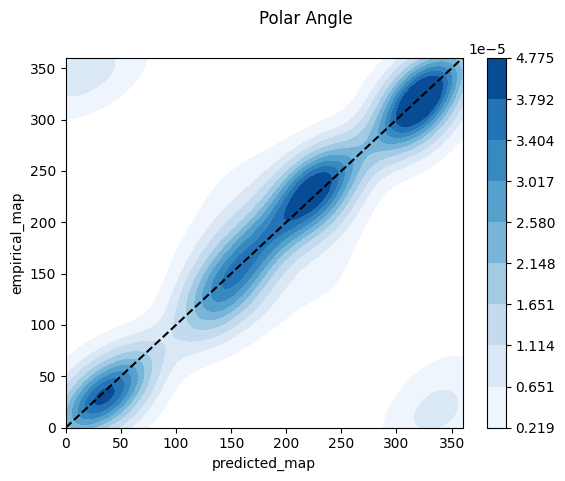

Threshold: 10
PearsonRResult(statistic=0.27361509709012233, pvalue=2.440523370695262e-255)


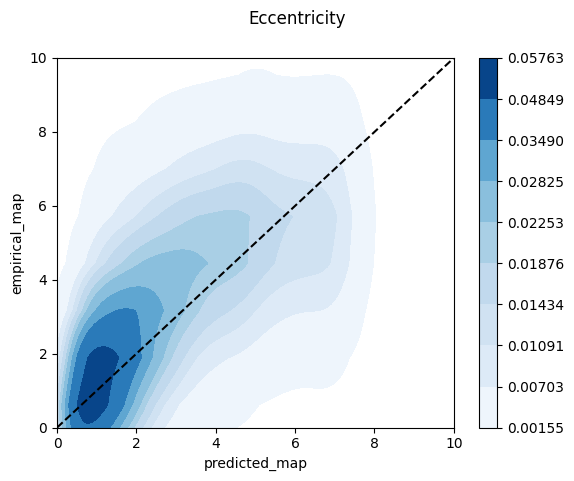

Threshold: 10
PearsonRResult(statistic=-0.03156214698819415, pvalue=0.0001120736470376248)


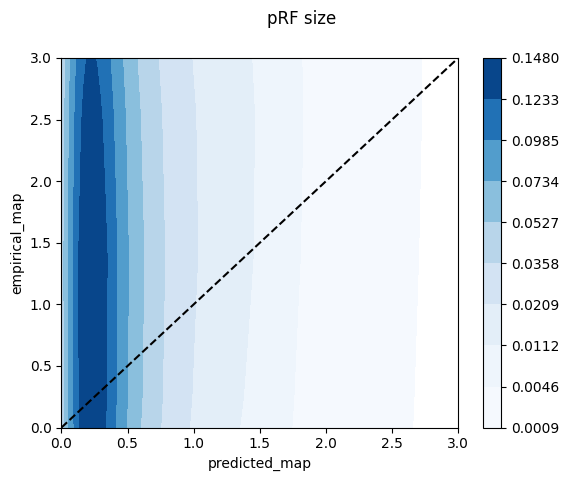

Region of interest: all
Threshold: 10
0.7883914709091187


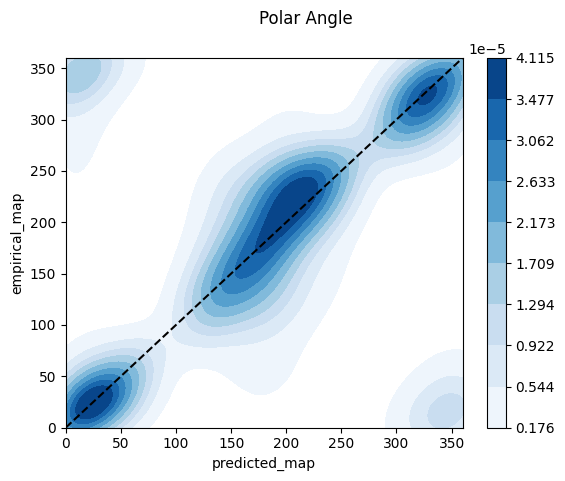

Threshold: 10
PearsonRResult(statistic=0.21747226220245502, pvalue=6.813828047227473e-270)


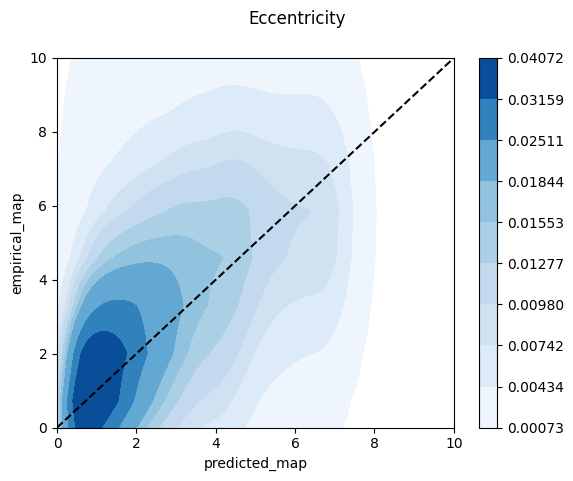

Threshold: 10
PearsonRResult(statistic=0.19615264402866067, pvalue=5.670417831861132e-219)


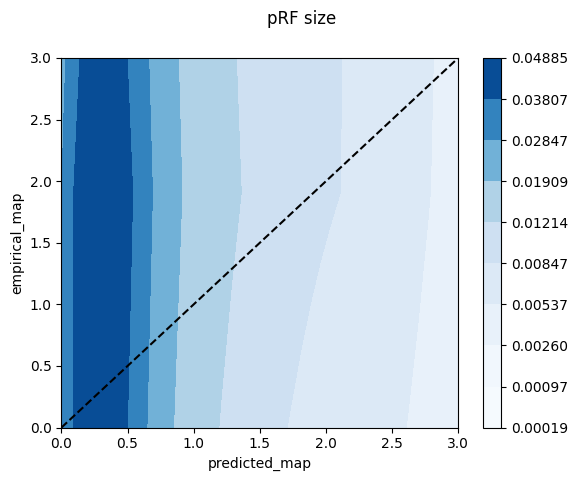

In [3]:
dataset_name = 'nsd'
path = '/BULK/LABDATA/NSD/freesurfer/'
retinotopic_maps = ['polarAngle', 'eccentricity', 'pRFsize']
for hemispheres in ['both']:
    for threshold in [10]:
        for roi in ['earlyvisualcortex', 'all']: # 'all', 'V1', 'V2', 'V3'
            predicted_vs_empirical(path, dataset_name, retinotopic_maps, hemispheres = hemispheres, threshold=threshold, region_of_interest=roi)

## Generate empirical vs. predicted values plots using bar-only model predictions

In [8]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import os

sys.path.append('./../')

from functions.evaluation import roi, roi_earlyvisualcortex, roi_parcel, return_list_of_subs, transform_polarangle
from astropy.stats import circcorrcoef
import astropy.units as u
import numpy as np
import nibabel as nib
import os.path as osp

def predicted_vs_empirical(path, dataset_name, retinotopic_maps, hemispheres, threshold = None, region_of_interest = 'all', stimulus = 'bars1bars2'):
    """Calculate the error between predicted and empirical maps for different models.
    
    Args:
        path (str): Path to the Freesurfer directory (both empirical and predicted maps should be 
            located at the deepRetinotopy folder within the individual's directory)
        list_of_sub_ids (list): List of subject IDs
        retinotopic_maps (list): List of retinotopic maps ('polarAngle', 'eccentricity' or 'pRFsize')
        hemispheres (str): Hemisphere ('lh', 'rh' or 'both')
        threshold (float): Threshold for the explained variance
        roi (str): Region of interest ('all', 'earlyvisualcortex', 'V1', 'V2' or 'V3')

    Returns:
        plt (matplotlib.pyplot): Scatter plot of the predicted vs empirical maps. 
            PNG file saved at the output folder.
    """

    # Number of nodes
    number_cortical_nodes = int(64984)
    number_hemi_nodes = int(number_cortical_nodes / 2)

    # Use data from both hemispheres or not
    if hemispheres == 'both':
        hemispheres = ['lh', 'rh']
    elif hemispheres == 'lh' or hemispheres == 'rh':
        hemispheres = [hemispheres]

    ## Region of interest
    # Region of interest used for training
    final_mask_L_ROI, final_mask_R_ROI, index_L_mask, index_R_mask = roi(['ROI'])
    # Early visual cortex
    final_mask_L, final_mask_R, index_L_mask, index_R_mask = roi_earlyvisualcortex(['ROI'])
    print('Region of interest: ' + region_of_interest)

    if region_of_interest != 'all' and region_of_interest != 'earlyvisualcortex':
        if region_of_interest == 'V1':
            areas = ['V1v', 'V1d']
        elif region_of_interest == 'V2':
            areas = ['V2v', 'V2d']
        elif region_of_interest == 'V3':
            areas = ['V3v', 'V3d']
        final_mask_L, final_mask_R, index_L_mask, index_R_mask = roi_parcel(areas)

    # Make output directory
    if os.path.isdir('../output/model_evaluation/nyu/') == False:
        os.makedirs('../output/model_evaluation/nyu/')

    # List of subjects
    list_of_sub_ids = return_list_of_subs(dataset_name)

    for retinotopic_map in retinotopic_maps:
        predicted_map = []
        empirical_map = []
        for hemisphere in hemispheres:
            ROI_masked = np.zeros((32492, 1))
            visualarea = np.zeros((32492, 1))
            predicted_map_hemi = []
            empirical_map_hemi = []
            if hemisphere == 'lh':
                ROI_masked[final_mask_L_ROI == 1] = 1
                visualarea[final_mask_L == 1] = 1
            else: 
                ROI_masked[final_mask_R_ROI == 1] = 1
                visualarea[final_mask_R == 1] = 1

            # Final mask 
            mask = ROI_masked + visualarea
            mask = mask == 2

            if region_of_interest == 'all':
                mask_final = ROI_masked
            else:
                mask_final = mask

            for i in range(len(list_of_sub_ids)):
                # Load predicted maps
                if stimulus == 'bars1bars2':
                    cmap_plot = 'Oranges'
                    tmp_predicted_map = np.array(nib.load(osp.join('/home/ribeiro/Projects/deepRetinotopy_validation/NYU_bar_model_predictions/predicted_bar_data_nyu', list_of_sub_ids[i] + '.fs_predicted_' + 
                                                        retinotopic_map + '_' + hemisphere + '_curvatureFeat_model_bars.func.gii')).agg_data()).reshape(
                                                        number_hemi_nodes, -1)[mask_final == 1]
                elif stimulus == 'wedge-ring':
                    cmap_plot = 'Reds'
                    tmp_predicted_map = np.array(nib.load(osp.join('/home/ribeiro/Projects/deepRetinotopy_validation/tmp/empirical_data_wedge-ring', list_of_sub_ids[i] + '.fs_empirical_' + 
                                                        retinotopic_map + '_' + hemisphere + '_masked_retccwretexpretcwretcon.func.gii')).agg_data()).reshape(
                                                        number_hemi_nodes, -1)[mask_final == 1]
                # Load empirical maps
                tmp_empirical_map = np.array(nib.load(osp.join(path, list_of_sub_ids[i] + '/surf/' + list_of_sub_ids[i] + '.fs_empirical_' + 
                                                    retinotopic_map + '_' + hemisphere + '.func.gii')).agg_data()).reshape(
                                                    number_hemi_nodes, -1)[mask_final == 1]
                                
                if threshold != None:
                    data_directory = '/surf/'
                    explained_variance = np.array(nib.load(osp.join(path, list_of_sub_ids[i] + data_directory + list_of_sub_ids[i] + '.fs_empirical_variance_explained_' +
                                                        hemisphere + '.func.gii')).agg_data()).reshape(
                                                        number_hemi_nodes, -1)[mask_final == 1]
                    tmp_predicted_map = tmp_predicted_map[explained_variance > threshold]              
                    tmp_empirical_map = tmp_empirical_map[explained_variance > threshold]

                # Transform polar angle values from lh to range from 0 to 90 and 270 to 360 degrees
                if retinotopic_map == 'polarAngle' and hemisphere == 'lh':
                    tmp_predicted_map = transform_polarangle(tmp_predicted_map) 
                    tmp_empirical_map = transform_polarangle(tmp_empirical_map) 

                predicted_map_hemi = predicted_map_hemi + list(np.array(tmp_predicted_map).flatten())
                empirical_map_hemi = empirical_map_hemi + list(np.array(tmp_empirical_map).flatten())

            predicted_map = predicted_map + list(np.array(predicted_map_hemi).flatten())
            empirical_map = empirical_map + list(np.array(empirical_map_hemi).flatten())
        
        if threshold != None:
            print('Threshold: ' + str(threshold))
        if stimulus == 'bars1bars2':
            name_data = 'Bar-only model'
        elif stimulus == 'wedge-ring':
            name_data = 'Wedge/Ring data'
        data = {name_data: predicted_map, 'Empirical data': empirical_map}
        data = pd.DataFrame(data)
        fig = plt.figure()
        # sns.kdeplot(y = data['Empirical data'], x =data[name_data],cmap=cmap_plot, fill=True,cbar=True)
        sns.jointplot(y = data['Empirical data'], x =data[name_data],color='orangered', kind='hex')

        if retinotopic_map ==  'polarAngle':
            plt.plot([0, 360], [0, 360], 'k--')
            plt.ylim(0,360)
            plt.xlim(0,360)
            if len(hemispheres) > 1:
                fig.suptitle('Polar Angle')
            else:
                fig.suptitle('Polar Angle - ' + hemispheres[0])
        elif retinotopic_map == 'eccentricity':
            plt.plot([0, 10], [0, 10], 'k--')
            plt.ylim(0,10)
            plt.xlim(0,10)
            if len(hemispheres) > 1:
                fig.suptitle('Eccentricity')
            else:
                fig.suptitle('Eccentricity - ' + hemispheres[0])

        elif retinotopic_map == 'pRFsize':
            plt.plot([0, 5], [0, 5], 'k--')
            plt.ylim(0,5)
            plt.xlim(0,5)
            if len(hemispheres) > 1:
                fig.suptitle('pRF size')
            else:
                fig.suptitle('pRF size - ' + hemispheres[0])
        if stimulus == 'bars1bars2':
            if threshold != None:
                plt.savefig('../output/model_evaluation/' + dataset_name + '/PredictedBarVsEmpirical_' + retinotopic_map + '_both_' + str(threshold) + '_' + region_of_interest + '_1.png')
            else:
                plt.savefig('../output/model_evaluation/' + dataset_name + '/PredictedBarVsEmpirical_' + retinotopic_map + '_both_' + region_of_interest + '_1.png')
        elif stimulus == 'wedge-ring':
            if threshold != None:
                plt.savefig('../output/model_evaluation/' + dataset_name + '/PredictedWedgeringVsEmpirical_' + retinotopic_map + '_both_' + str(threshold) + '_' + region_of_interest + '.png')
            else:
                plt.savefig('../output/model_evaluation/' + dataset_name + '/PredictedWedgeringVsEmpirical_' + retinotopic_map + '_both_' + region_of_interest + '.png')
        plt.show()
    return

Region of interest: earlyvisualcortex
Threshold: 0.1


<Figure size 640x480 with 0 Axes>

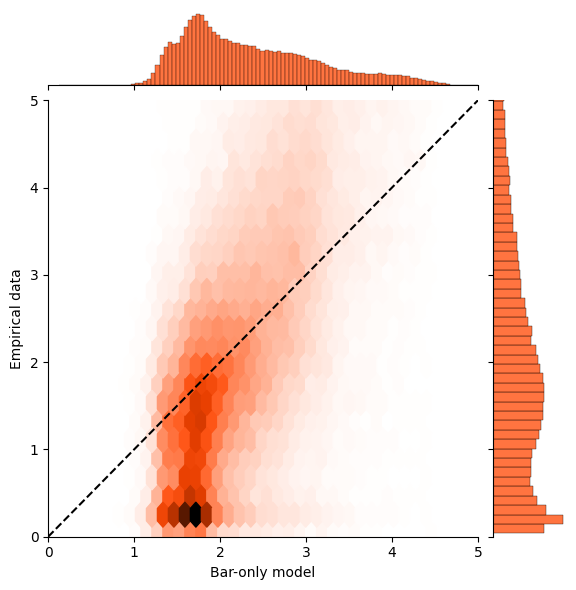

Threshold: 0.1


<Figure size 640x480 with 0 Axes>

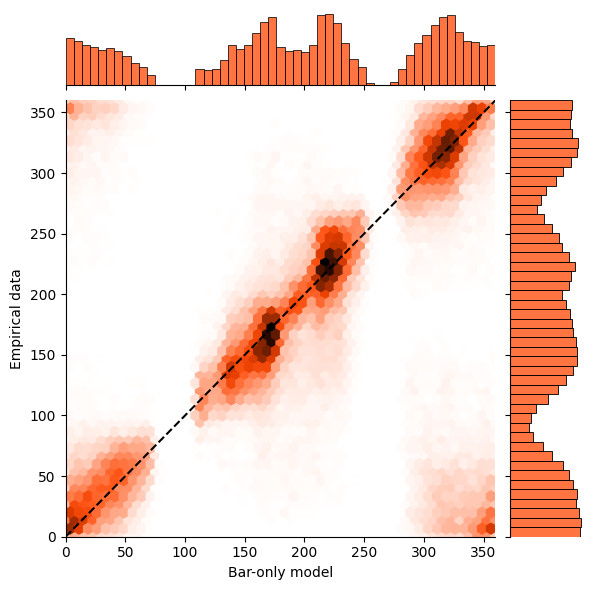

Threshold: 0.1


<Figure size 640x480 with 0 Axes>

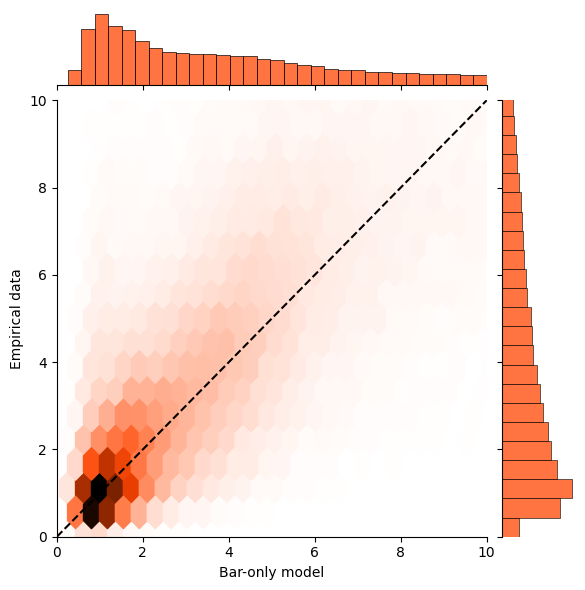

In [9]:
dataset_name = 'nyu'
path = '/BULK/LABDATA/openneuro/ds003787/derivatives/freesurfer'
retinotopic_maps = ['pRFsize', 'polarAngle', 'eccentricity']
for hemispheres in ['both']:
    for threshold in [0.1]:
        predicted_vs_empirical(path, dataset_name, retinotopic_maps, hemispheres = hemispheres, threshold=threshold, region_of_interest = 'earlyvisualcortex')